In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


1.11.0+cu113
     |████████████████████████████████| 7.9 MB 34.6 MB/s 
     |████████████████████████████████| 3.5 MB 28.3 MB/s 


In [2]:
pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 29.1 MB/s 
     |████████████████████████████████| 22.7 MB 19.3 MB/s 


In [3]:
import torch
import pandas as pd
import numpy as np
import torch_geometric.transforms as T
import torch_geometric
from torch_geometric.data import Dataset
import numpy as np 
import os
import deepchem as dc
import torch.nn as nn
from torch.nn import Linear,BatchNorm1d
from torch_geometric.nn import GCNConv,GATConv
from torch_geometric.nn import BatchNorm
from tqdm import tqdm
from torch_geometric.data import DataLoader
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
import seaborn as sns
import pandas as pd 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import math
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv('raw/totalData.csv')
data.head() 

,Unnamed: 0,Drug1_ID,Drug1_SMILES
0,0,DB00706,CCOc1ccccc1OCCN[C@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1
1,1,DB01023,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl
2,2,3849.0,C[C@@H](Oc1ccc2[nH]nc(/C=C/c3cnn(CCO)c3)c2c1)c...
3,3,3515.0,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(I)cc1
4,4,6380.0,O=P(O)(O)OCCCc1c[nH]c2ccccc12


In [5]:
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

remove = []

class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        self.sz = 0
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        count = 0
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            # Featurize molecule
            if type(mol["Drug1_SMILES"])==float:
              remove.append(mol["Drug1_ID"])
              continue
            f = featurizer.featurize(mol["Drug1_SMILES"])
            if not f : 
              remove.append(mol["Drug1_ID"])
              print(count)
              continue
            data = f[0].to_pyg_graph()
            data.y = 1
            data.smiles = mol["Drug1_SMILES"]
            data.id = mol["Drug1_ID"]
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                f'data_test_{count}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                f'data_{count}.pt'))
            count+=1
        self.sz = count

    def _get_label(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.sz
        #return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))        
        return data

encoder_set = MoleculeDataset("","totalData.csv")

Processing...


Torch version: 1.11.0+cu113
Cuda available: True
Torch geometric version: 2.0.5


  1%|          | 59/10951 [00:00<01:58, 92.28it/s]Failed to featurize datapoint 0, [Mg+2].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  1%|          | 69/10951 [00:00<02:02, 89.07it/s]Failed to featurize datapoint 0, [Gd+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  1%|          | 79/10951 [00:01<02:07, 85.13it/s]

68
76


  1%|▏         | 149/10951 [00:02<02:43, 65.91it/s]Failed to featurize datapoint 0, [81Kr]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  1%|▏         | 158/10951 [00:02<02:44, 65.61it/s]Failed to featurize datapoint 0, [Li+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


149
163


  3%|▎         | 349/10951 [00:05<01:58, 89.12it/s]Failed to featurize datapoint 0, [Al+3].[OH-].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  3%|▎         | 369/10951 [00:05<02:04, 85.04it/s]

349


  4%|▍         | 425/10951 [00:06<02:06, 83.01it/s]Failed to featurize datapoint 0, [I-].[K+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
Failed to featurize datapoint 0, [Sb+5]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  4%|▍         | 435/10951 [00:06<02:04, 84.18it/s]

420
427


  5%|▍         | 495/10951 [00:07<01:56, 89.75it/s]Failed to featurize datapoint 0, [Cr+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  5%|▍         | 515/10951 [00:07<01:55, 90.51it/s]

491


  5%|▌         | 595/10951 [00:08<01:58, 87.05it/s]Failed to featurize datapoint 0, [Fe]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  6%|▌         | 616/10951 [00:08<01:58, 86.99it/s]

590


  6%|▌         | 636/10951 [00:08<02:03, 83.66it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Mg+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  6%|▌         | 655/10951 [00:09<01:59, 85.97it/s]

629


  8%|▊         | 919/10951 [00:15<06:08, 27.22it/s]Failed to featurize datapoint 0, [Mg+2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
  8%|▊         | 923/10951 [00:16<06:51, 24.36it/s]

911


  9%|▊         | 942/10951 [00:16<04:08, 40.34it/s]Failed to featurize datapoint 0, [13NH3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  9%|▊         | 955/10951 [00:16<03:28, 48.00it/s]

934


  9%|▉         | 1017/10951 [00:18<04:07, 40.16it/s]Failed to featurize datapoint 0, [Zn+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
  9%|▉         | 1030/10951 [00:18<03:40, 45.03it/s]

1008


 11%|█         | 1218/10951 [00:23<05:03, 32.10it/s]Failed to featurize datapoint 0, [I-].[K+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 11%|█         | 1224/10951 [00:23<04:20, 37.35it/s]

1205


 11%|█▏        | 1237/10951 [00:24<03:37, 44.57it/s]Failed to featurize datapoint 0, [131I-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 11%|█▏        | 1242/10951 [00:24<03:57, 40.94it/s]

1224


 12%|█▏        | 1284/10951 [00:25<05:50, 27.58it/s]Failed to featurize datapoint 0, [Cl-].[NH4+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 12%|█▏        | 1292/10951 [00:25<06:02, 26.67it/s]

1271


 12%|█▏        | 1316/10951 [00:26<05:13, 30.77it/s]Failed to featurize datapoint 0, [89Sr+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 12%|█▏        | 1326/10951 [00:27<04:50, 33.09it/s]

1304


 14%|█▍        | 1533/10951 [00:33<03:54, 40.10it/s]Failed to featurize datapoint 0, [3He]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 14%|█▍        | 1538/10951 [00:33<03:42, 42.24it/s]

1518


 14%|█▍        | 1557/10951 [00:34<03:12, 48.79it/s]Failed to featurize datapoint 0, [Cl-].[K+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 14%|█▍        | 1571/10951 [00:34<03:05, 50.49it/s]

1545


Failed to featurize datapoint 0, [La+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 0, [Zn]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 14%|█▍        | 1577/10951 [00:34<03:02, 51.34it/s]

1554
1554


 15%|█▌        | 1670/10951 [00:39<13:27, 11.49it/s]Failed to featurize datapoint 0, [Co]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 15%|█▌        | 1686/10951 [00:39<07:44, 19.95it/s]

1656


 17%|█▋        | 1833/10951 [00:41<02:06, 72.03it/s]Failed to featurize datapoint 0, O.O.O.O.[98Tc-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 17%|█▋        | 1853/10951 [00:41<01:50, 82.14it/s]

1811


 18%|█▊        | 1932/10951 [00:42<01:57, 76.79it/s]Failed to featurize datapoint 0, [Na+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 18%|█▊        | 1940/10951 [00:42<02:11, 68.33it/s]

1913


 18%|█▊        | 1957/10951 [00:42<02:04, 71.98it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Sn+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 18%|█▊        | 1977/10951 [00:42<01:49, 81.62it/s]Failed to featurize datapoint 0, [Mg+2].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity


1942
1961


 20%|█▉        | 2140/10951 [00:44<01:37, 90.37it/s] Failed to featurize datapoint 0, O. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 20%|█▉        | 2165/10951 [00:44<01:25, 102.61it/s]

2116


 24%|██▍       | 2666/10951 [00:50<01:24, 98.48it/s]Failed to featurize datapoint 0, [89Sr+2].[Cl-].[Cl-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 25%|██▍       | 2686/10951 [00:50<01:32, 88.95it/s]

2643


 26%|██▌       | 2809/10951 [00:52<01:24, 96.60it/s] Failed to featurize datapoint 0, [Cl-].[Cl-].[Zn+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 26%|██▌       | 2819/10951 [00:52<01:26, 94.05it/s]Failed to featurize datapoint 0, [Pt]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 26%|██▌       | 2829/10951 [00:52<01:30, 89.43it/s]

2788
2795


 26%|██▌       | 2840/10951 [00:52<01:27, 92.38it/s]Failed to featurize datapoint 0, [223Ra+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 0, [67Ga+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 26%|██▌       | 2861/10951 [00:52<01:27, 92.51it/s]

2811
2815


 26%|██▌       | 2871/10951 [00:52<01:34, 85.88it/s]Failed to featurize datapoint 0, [Ne]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 26%|██▋       | 2884/10951 [00:53<01:23, 96.33it/s]

2848


 29%|██▊       | 3138/10951 [00:56<02:04, 62.84it/s]Failed to featurize datapoint 0, [32PH3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 29%|██▉       | 3151/10951 [00:56<01:37, 79.81it/s]Failed to featurize datapoint 0, [K+].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 29%|██▉       | 3164/10951 [00:56<01:24, 91.92it/s]

3111
3128


 30%|██▉       | 3239/10951 [00:57<01:17, 99.45it/s]Failed to featurize datapoint 0, [Ac]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 30%|██▉       | 3250/10951 [00:57<01:16, 101.24it/s]Failed to featurize datapoint 0, F. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 30%|██▉       | 3261/10951 [00:57<01:15, 102.24it/s]

3212
3222


 30%|███       | 3295/10951 [00:58<01:18, 97.09it/s] Failed to featurize datapoint 0, [Al+3].[Al+3].[O-2].[O-2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 30%|███       | 3305/10951 [00:58<01:33, 81.69it/s]

3258


 30%|███       | 3315/10951 [00:58<01:29, 85.70it/s]Failed to featurize datapoint 0, [Cl-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 30%|███       | 3326/10951 [00:58<01:23, 90.87it/s]

3283


 32%|███▏      | 3480/10951 [01:00<01:25, 87.14it/s]Failed to featurize datapoint 0, [Ag+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 32%|███▏      | 3489/10951 [01:00<01:26, 86.12it/s]

3444


 33%|███▎      | 3585/10951 [01:01<01:25, 86.46it/s]Failed to featurize datapoint 0, [Ca+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 33%|███▎      | 3596/10951 [01:01<01:21, 90.79it/s]Failed to featurize datapoint 0, [Cl-].[NH4+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity


3546
3563


 34%|███▍      | 3767/10951 [01:04<01:41, 71.08it/s]Failed to featurize datapoint 0, [Al+3].[OH-].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 34%|███▍      | 3776/10951 [01:04<01:38, 72.99it/s]Failed to featurize datapoint 0, [Ca+2].[Cl-].[Cl-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 35%|███▍      | 3787/10951 [01:04<01:27, 81.54it/s]

3733
3741


 35%|███▍      | 3828/10951 [01:05<01:19, 89.24it/s]Failed to featurize datapoint 0, [Ta]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 35%|███▌      | 3838/10951 [01:05<01:21, 87.18it/s]Failed to featurize datapoint 0, [Bk]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 35%|███▌      | 3849/10951 [01:05<01:18, 90.31it/s]

3787
3802


 36%|███▋      | 3984/10951 [01:06<01:20, 86.07it/s]Failed to featurize datapoint 0, [Li+].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 36%|███▋      | 3994/10951 [01:06<01:18, 88.28it/s]

3940


 37%|███▋      | 4045/10951 [01:08<02:45, 41.81it/s]Failed to featurize datapoint 0, [Ti]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 37%|███▋      | 4060/10951 [01:08<02:18, 49.63it/s]

4000


Failed to featurize datapoint 0, [Co+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 37%|███▋      | 4080/10951 [01:08<01:43, 66.37it/s]

4015


 38%|███▊      | 4150/10951 [01:09<01:20, 83.99it/s]Failed to featurize datapoint 0, [Fe]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 38%|███▊      | 4171/10951 [01:09<01:19, 84.76it/s]

4108


 38%|███▊      | 4180/10951 [01:09<01:24, 80.01it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Cl-].[Cr+3]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 38%|███▊      | 4200/10951 [01:09<01:19, 85.12it/s]

4138


 39%|███▉      | 4249/10951 [01:10<01:21, 81.84it/s]Failed to featurize datapoint 0, [99Tc]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 39%|███▉      | 4271/10951 [01:10<01:24, 79.39it/s]

4206


 41%|████      | 4443/10951 [01:13<01:23, 78.22it/s]Failed to featurize datapoint 0, [131I-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 41%|████      | 4463/10951 [01:13<01:17, 83.99it/s]

4395


 41%|████      | 4500/10951 [01:13<01:19, 80.71it/s]Failed to featurize datapoint 0, [Ba]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 0, [Mo]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 41%|████▏     | 4518/10951 [01:14<01:17, 82.70it/s]

4452
4453


 43%|████▎     | 4724/10951 [01:16<01:32, 67.21it/s]Failed to featurize datapoint 0, [Cd]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 43%|████▎     | 4734/10951 [01:16<01:23, 74.37it/s]

4676


 43%|████▎     | 4751/10951 [01:17<02:06, 48.87it/s]Failed to featurize datapoint 0, [123I-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 44%|████▎     | 4774/10951 [01:17<01:28, 69.45it/s]

4703


 45%|████▌     | 4955/10951 [01:19<01:14, 80.33it/s]Failed to featurize datapoint 0, [P]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 45%|████▌     | 4973/10951 [01:19<01:11, 83.24it/s]

4899


 46%|████▌     | 5011/10951 [01:20<01:12, 81.38it/s]Failed to featurize datapoint 0, [Li+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 46%|████▌     | 5032/10951 [01:20<01:06, 88.54it/s]

4962


 46%|████▌     | 5044/10951 [01:20<01:01, 96.32it/s]Failed to featurize datapoint 0, [OH-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 46%|████▌     | 5063/10951 [01:21<01:11, 81.96it/s]

4994


 47%|████▋     | 5197/10951 [01:22<01:06, 86.69it/s]Failed to featurize datapoint 0, [Se]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 48%|████▊     | 5217/10951 [01:22<01:02, 92.12it/s]

5143


 48%|████▊     | 5254/10951 [01:23<01:12, 78.82it/s]Failed to featurize datapoint 0, [I-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 48%|████▊     | 5273/10951 [01:23<01:08, 83.20it/s]

5201


 49%|████▉     | 5348/10951 [01:24<00:55, 101.04it/s]Failed to featurize datapoint 0, [Cl-].[Tl+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 49%|████▉     | 5369/10951 [01:24<01:03, 88.27it/s]Failed to featurize datapoint 0, [18F]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


5296
5312


 50%|████▉     | 5448/10951 [01:25<00:57, 95.12it/s]Failed to featurize datapoint 0, [V]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 50%|████▉     | 5468/10951 [01:25<00:57, 95.00it/s]

5385


Failed to featurize datapoint 0, [82Rb+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 50%|█████     | 5478/10951 [01:25<01:05, 83.20it/s]

5406


 51%|█████     | 5545/10951 [01:26<01:16, 70.62it/s]Failed to featurize datapoint 0, [Cl-].[K+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 51%|█████     | 5555/10951 [01:26<01:10, 76.41it/s]Failed to featurize datapoint 0, [51Cr]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 51%|█████     | 5566/10951 [01:26<01:03, 84.77it/s]

5487
5491


 51%|█████     | 5588/10951 [01:27<00:57, 93.22it/s]Failed to featurize datapoint 0, [Sb]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 51%|█████     | 5602/10951 [01:27<00:51, 104.24it/s]Failed to featurize datapoint 0, [177Lu]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 51%|█████▏    | 5613/10951 [01:27<00:52, 102.00it/s]

5526
5533


 52%|█████▏    | 5667/10951 [01:27<00:53, 99.28it/s]Failed to featurize datapoint 0, [C]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 52%|█████▏    | 5688/10951 [01:28<01:04, 81.22it/s]

5604


 52%|█████▏    | 5709/10951 [01:28<00:58, 90.35it/s]Failed to featurize datapoint 0, [Rb]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 52%|█████▏    | 5731/10951 [01:28<00:53, 98.17it/s]

5640


 53%|█████▎    | 5797/10951 [01:29<00:50, 101.16it/s]Failed to featurize datapoint 0, [Zn]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 53%|█████▎    | 5820/10951 [01:29<00:49, 103.50it/s]

5729


 56%|█████▋    | 6180/10951 [01:36<01:33, 51.05it/s]Failed to featurize datapoint 0, [Fe+3].[O-2].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 57%|█████▋    | 6203/10951 [01:36<01:05, 72.85it/s]

6112


 59%|█████▉    | 6489/10951 [01:43<01:18, 56.53it/s]Failed to featurize datapoint 0, [90Y]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 59%|█████▉    | 6507/10951 [01:43<01:14, 59.97it/s]

6422


 60%|█████▉    | 6544/10951 [01:44<01:09, 63.08it/s]Failed to featurize datapoint 0, O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.[Mo].[Mo].[Mo].[Mo].[Mo].[Mo].[Mo].[OH-].[OH-].[OH-].[OH-].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 60%|█████▉    | 6563/10951 [01:44<01:02, 70.33it/s]

6479


 60%|██████    | 6573/10951 [01:44<00:56, 77.44it/s]Failed to featurize datapoint 0, [153Sm]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 60%|██████    | 6591/10951 [01:44<00:54, 80.42it/s]

6502


 62%|██████▏   | 6775/10951 [01:48<00:41, 100.13it/s]Failed to featurize datapoint 0, [Cr]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 62%|██████▏   | 6787/10951 [01:48<00:39, 104.28it/s]Failed to featurize datapoint 0, [Na+].[Na+].[S-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 62%|██████▏   | 6798/10951 [01:48<00:42, 98.40it/s] 

6707
6717


 63%|██████▎   | 6853/10951 [01:49<00:43, 93.36it/s]Failed to featurize datapoint 0, [201Tl+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 63%|██████▎   | 6864/10951 [01:49<00:42, 96.99it/s]

6776


 65%|██████▌   | 7125/10951 [01:52<01:02, 61.69it/s]Failed to featurize datapoint 0, [B]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 65%|██████▌   | 7141/10951 [01:52<00:58, 64.63it/s]

7050


 65%|██████▌   | 7154/10951 [01:52<00:47, 79.85it/s]Failed to featurize datapoint 0, O.[Al+3].[Al+3].[Cl-].[OH-].[OH-].[OH-].[OH-].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 66%|██████▌   | 7175/10951 [01:52<00:45, 83.55it/s]

7079


 67%|██████▋   | 7303/10951 [01:54<00:41, 88.92it/s]Failed to featurize datapoint 0, [Mg+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 67%|██████▋   | 7324/10951 [01:54<00:38, 93.88it/s]

7229


 67%|██████▋   | 7344/10951 [01:54<00:41, 86.74it/s]Failed to featurize datapoint 0, Br.Br.Br.Br.Br.Br.Br.Br.Br.Br.Br.[Br-].[Ta+].[Ta].[Ta].[Ta].[Ta].[Ta]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 67%|██████▋   | 7353/10951 [01:54<00:41, 87.06it/s]

7261


 68%|██████▊   | 7409/10951 [01:55<00:43, 80.99it/s]Failed to featurize datapoint 0, [Fe+2].[Fe+3].[Fe+3].[O-2].[O-2].[O-2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 68%|██████▊   | 7430/10951 [01:55<00:41, 85.31it/s]

7329


 68%|██████▊   | 7450/10951 [01:55<00:40, 86.68it/s]Failed to featurize datapoint 0, [Ca+2].[Cl-].[Cl-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 68%|██████▊   | 7469/10951 [01:56<00:40, 85.12it/s]

7370


 69%|██████▊   | 7515/10951 [02:02<07:44,  7.40it/s]Failed to featurize datapoint 0, [Al]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 69%|██████▊   | 7521/10951 [02:03<06:32,  8.73it/s]

7432


 69%|██████▉   | 7549/10951 [02:03<02:19, 24.40it/s]Failed to featurize datapoint 0, [Mn+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 69%|██████▉   | 7569/10951 [02:03<01:18, 42.92it/s]

7466


 69%|██████▉   | 7587/10951 [02:04<00:58, 57.75it/s]Failed to featurize datapoint 0, [223Ra]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 69%|██████▉   | 7597/10951 [02:04<00:51, 64.53it/s]

7507


 71%|███████   | 7732/10951 [02:06<00:40, 78.94it/s]Failed to featurize datapoint 0, [I-].[Na+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 71%|███████   | 7751/10951 [02:06<00:38, 83.88it/s]

7646


 72%|███████▏  | 7847/10951 [02:07<00:55, 56.18it/s]Failed to featurize datapoint 0, [Ag]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 72%|███████▏  | 7868/10951 [02:08<00:42, 73.31it/s]

7758


 76%|███████▌  | 8269/10951 [02:13<00:34, 77.23it/s]Failed to featurize datapoint 0, [C]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 76%|███████▌  | 8286/10951 [02:13<00:39, 67.33it/s]

8184


 76%|███████▌  | 8343/10951 [02:14<00:32, 81.05it/s]Failed to featurize datapoint 0, [Si]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 76%|███████▋  | 8363/10951 [02:14<00:29, 86.40it/s]

8251


 76%|███████▋  | 8372/10951 [02:14<00:31, 81.58it/s]Failed to featurize datapoint 0, O.O.O.O.[Al+3].[Mg+2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[OH-].[Si+4].[Si+4].[Si+4].[Si+4]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 77%|███████▋  | 8394/10951 [02:15<00:31, 80.27it/s]

8289


 77%|███████▋  | 8446/10951 [02:15<00:28, 87.48it/s]Failed to featurize datapoint 0, [Bi+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 77%|███████▋  | 8466/10951 [02:15<00:29, 84.24it/s]

8357


 77%|███████▋  | 8477/10951 [02:16<00:27, 90.76it/s]Failed to featurize datapoint 0, [Cl-].[Na+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 78%|███████▊  | 8489/10951 [02:16<00:25, 96.68it/s]

8383


 78%|███████▊  | 8544/10951 [02:16<00:25, 95.59it/s]Failed to featurize datapoint 0, [F-].[Na+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 78%|███████▊  | 8564/10951 [02:17<00:31, 76.99it/s]

8456


 79%|███████▊  | 8608/10951 [02:17<00:24, 96.60it/s]Failed to featurize datapoint 0, [F-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 79%|███████▉  | 8630/10951 [02:17<00:23, 98.87it/s]

8520


 80%|████████  | 8780/10951 [02:19<00:31, 69.61it/s]Failed to featurize datapoint 0, [KH]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 80%|████████  | 8800/10951 [02:19<00:26, 81.25it/s]

8687


 83%|████████▎ | 9045/10951 [02:22<00:22, 84.53it/s]Failed to featurize datapoint 0, [Cu+2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 83%|████████▎ | 9066/10951 [02:22<00:20, 92.29it/s]

8954


 83%|████████▎ | 9100/10951 [02:23<00:18, 99.47it/s]Failed to featurize datapoint 0, [Al+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 83%|████████▎ | 9110/10951 [02:23<00:19, 94.24it/s]

9001


 84%|████████▎ | 9170/10951 [02:23<00:22, 79.17it/s]Failed to featurize datapoint 0, [Cu]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 84%|████████▍ | 9188/10951 [02:24<00:22, 78.63it/s]Failed to featurize datapoint 0, [MgH2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


9073
9087


 86%|████████▌ | 9389/10951 [02:26<00:16, 97.58it/s]Failed to featurize datapoint 0, [Fe+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 86%|████████▌ | 9409/10951 [02:26<00:16, 94.21it/s]

9293


 87%|████████▋ | 9494/10951 [02:27<00:18, 79.50it/s]Failed to featurize datapoint 0, [Cu+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 87%|████████▋ | 9516/10951 [02:27<00:15, 91.71it/s]

9399


 87%|████████▋ | 9539/10951 [02:28<00:16, 85.97it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Co+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 87%|████████▋ | 9549/10951 [02:28<00:16, 87.16it/s]Failed to featurize datapoint 0, [Nb]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 87%|████████▋ | 9561/10951 [02:28<00:14, 94.58it/s]

9436
9454


 88%|████████▊ | 9592/10951 [02:28<00:14, 92.22it/s]Failed to featurize datapoint 0, [Au]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 88%|████████▊ | 9615/10951 [02:29<00:13, 97.93it/s]

9485


 88%|████████▊ | 9644/10951 [02:29<00:15, 85.15it/s]Failed to featurize datapoint 0, [133Xe]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 88%|████████▊ | 9669/10951 [02:29<00:12, 102.65it/s]

9541


 89%|████████▉ | 9774/10951 [02:30<00:12, 92.09it/s]Failed to featurize datapoint 0, [Sm]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 89%|████████▉ | 9792/10951 [02:31<00:16, 72.01it/s]

9669


 90%|████████▉ | 9818/10951 [02:31<00:14, 76.44it/s]Failed to featurize datapoint 0, [Na+].[OH-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 90%|████████▉ | 9828/10951 [02:31<00:13, 81.72it/s]

9709


 91%|█████████ | 9962/10951 [02:33<00:13, 76.03it/s]Failed to featurize datapoint 0, [He]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 91%|█████████ | 9972/10951 [02:33<00:12, 81.13it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Mg+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
Failed to featurize datapoint 0, [Mg+2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 91%|█████████ | 9982/10951 [02:33<00:11, 84.46it/s]

9857
9864
9866


 93%|█████████▎| 10146/10951 [02:35<00:08, 90.87it/s]Failed to featurize datapoint 0, [Fe+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 93%|█████████▎| 10167/10951 [02:35<00:08, 91.11it/s]

10038


 93%|█████████▎| 10190/10951 [02:35<00:08, 94.83it/s]Failed to featurize datapoint 0, [111In+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 0, [67Ga+3].[Cl-].[Cl-].[Cl-]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 93%|█████████▎| 10202/10951 [02:35<00:07, 101.22it/s]

10077
10082


 93%|█████████▎| 10213/10951 [02:35<00:09, 79.35it/s] Failed to featurize datapoint 0, [Ni+2]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 0, [Se]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 93%|█████████▎| 10233/10951 [02:36<00:08, 83.86it/s]

10101
10103


 94%|█████████▎| 10252/10951 [02:36<00:07, 87.38it/s]Failed to featurize datapoint 0, [Ca]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 94%|█████████▍| 10272/10951 [02:36<00:07, 86.90it/s]Failed to featurize datapoint 0, [K+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


10138
10154


 95%|█████████▌| 10409/10951 [02:38<00:09, 56.93it/s]Failed to featurize datapoint 0, [Ga+3]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 95%|█████████▌| 10428/10951 [02:38<00:07, 71.03it/s]

10295


 95%|█████████▌| 10448/10951 [02:39<00:09, 54.07it/s]Failed to featurize datapoint 0, [Gd]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 96%|█████████▌| 10466/10951 [02:39<00:07, 67.38it/s]

10328


 96%|█████████▌| 10486/10951 [02:39<00:05, 78.23it/s]Failed to featurize datapoint 0, O.O.O.O.[Mo+6].[Mo+6].[Mo+6].[Mo+6].[Mo+6].[Mo+6].[Mo+6].[NH4+].[NH4+].[NH4+].[NH4+].[NH4+].[NH4+].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
 96%|█████████▌| 10506/10951 [02:39<00:05, 85.55it/s]Failed to featurize datapoint 0, [Mg+2].[O-2].[O-2].[O-2].[Si+4]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity


10370
10383


 97%|█████████▋| 10647/10951 [02:41<00:03, 83.34it/s]Failed to featurize datapoint 0, [18F-]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 97%|█████████▋| 10667/10951 [02:41<00:03, 84.87it/s]

10529


 98%|█████████▊| 10753/10951 [02:42<00:02, 72.20it/s]Failed to featurize datapoint 0, [Au+]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
 98%|█████████▊| 10766/10951 [02:42<00:02, 85.02it/s]

10627


 99%|█████████▉| 10845/10951 [02:43<00:01, 87.70it/s]Failed to featurize datapoint 0, [In]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


10718


100%|█████████▉| 10900/10951 [02:44<00:00, 84.17it/s]Failed to featurize datapoint 0, [Cl-].[Cl-].[Sr+2]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity
100%|█████████▉| 10910/10951 [02:44<00:00, 85.51it/s]Failed to featurize datapoint 0, [111In]. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


10778
10782


100%|█████████▉| 10919/10951 [02:44<00:00, 65.93it/s]Failed to featurize datapoint 0, [Cl-].[Na+]. Appending empty array
Exception message: zero-size array to reduction operation maximum which has no identity


10789


100%|██████████| 10951/10951 [02:46<00:00, 65.96it/s]
Done!


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
class GVAE(nn.Module):
    def __init__(self, feature_size, edge_size):
        super(GVAE, self).__init__()
        self.encoder_embedding_size = 64
        self.edge_dim = edge_size
        self.latent_embedding_size = 8
        self.decoder_hidden_neurons = 64
        decoder_size = 64

        # Encoder layers
        self.conv1 = GATConv(feature_size, self.encoder_embedding_size,edge_dim=self.edge_dim)
        self.bn1 = BatchNorm(self.encoder_embedding_size)
        self.conv2 = GCNConv(self.encoder_embedding_size, self.encoder_embedding_size)
        self.bn2 = BatchNorm(self.encoder_embedding_size)
        self.conv3 = GCNConv(self.encoder_embedding_size, self.encoder_embedding_size)
        self.bn3 = BatchNorm(self.encoder_embedding_size)
        

        # Latent transform layers
        self.mu_transform = Linear(self.encoder_embedding_size, 
                                            self.latent_embedding_size)


        self.decoder_dense_3 = Linear(self.latent_embedding_size*2, decoder_size)
        self.decoder_bn_3 = BatchNorm1d(decoder_size)
        self.decoder_dense_4 = Linear(decoder_size, 1)
        

    def encode(self, x, edge_attr, edge_index, batch_index):
        # GNN layers
        x = self.conv1(x, edge_index, edge_attr).relu()
        x = self.bn1(x)
        x = self.conv2(x, edge_index).relu()
        x = self.bn2(x)
        x = self.conv3(x, edge_index).relu()
        x = self.bn3(x)
        
        # Latent transform layers
        mu = self.mu_transform(x)
        return mu


    def decode(self, z, batch_index):
        """
        Takes n latent vectors (one per node) and decodes them
        into the upper triangular part of their adjacency matrix.
        """
        inputs = []

        # Iterate over molecules in batch
        for graph_id in torch.unique(batch_index):
            graph_mask = torch.eq(batch_index, graph_id)
            graph_z = z[graph_mask]

            # Get indices for triangular upper part of adjacency matrix
            edge_indices = torch.triu_indices(graph_z.shape[0], graph_z.shape[0], offset=1)

            # Repeat indices to match dim of latent codes
            dim = self.latent_embedding_size
            source_indices = torch.reshape(edge_indices[0].repeat_interleave(dim), (edge_indices.shape[1], dim))
            target_indices = torch.reshape(edge_indices[1].repeat_interleave(dim), (edge_indices.shape[1], dim))

            # Gather features
            sources_feats = torch.gather(graph_z, 0, source_indices.to(device))
            target_feats = torch.gather(graph_z, 0, target_indices.to(device))

            # Concatenate inputs of all source and target nodes
            graph_inputs = torch.cat([sources_feats, target_feats], axis=1)
            inputs.append(graph_inputs)

        # Concatenate all inputs of all graphs in the batch
        inputs = torch.cat(inputs)

       
        x = self.decoder_dense_3(inputs).relu()
        x = self.decoder_bn_3(x)
        edge_logits = self.decoder_dense_4(x)

        return edge_logits


    def reparameterize(self, mu):
        """
        The reparametrization trick is required to 
        backpropagate through the network.
        We cannot backpropagate through a "sampled"
        node as it is not deterministic.
        The trick is to separate the randomness
        from the network.
        """
        return mu

    def forward(self, x, edge_attr, edge_index, batch_index):
        # Encode the molecule
        mu = self.encode(x, edge_attr, edge_index, batch_index)
        # Sample latent vector (per atom)
        z = self.reparameterize(mu)
        # Decode latent vector into original molecule
        triu_logits = self.decode(z, batch_index)

        return triu_logits, mu

    
   
model = GVAE(feature_size=encoder_set[0].x.shape[1],edge_size=encoder_set[0].edge_attr.shape[1])
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GVAE(
  (conv1): GATConv(30, 64, heads=1)
  (bn1): BatchNorm(64)
  (conv2): GCNConv(64, 64)
  (bn2): BatchNorm(64)
  (conv3): GCNConv(64, 64)
  (bn3): BatchNorm(64)
  (mu_transform): Linear(in_features=64, out_features=8, bias=True)
  (decoder_dense_3): Linear(in_features=16, out_features=64, bias=True)
  (decoder_bn_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_dense_4): Linear(in_features=64, out_features=1, bias=True)
)
Number of parameters:  13385


In [8]:
data_size = len(encoder_set)
NUM_GRAPHS_PER_BATCH = 64
frac = 0.5
train_loader = DataLoader(encoder_set[:int(data_size * frac)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(encoder_set[int(data_size * frac):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)


model = model.to(device)


In [13]:
from torch_geometric.utils import to_dense_adj

def slice_graph_targets(graph_id, batch_targets, batch_index):
    """
    Slices out the upper triangular part of an adjacency matrix for
    a single graph from a large adjacency matrix for a full batch.
    --------
    graph_id: The ID of the graph (in the batch index) to slice
    batch_targets: A dense adjacency matrix for the whole batch
    batch_index: The node to graph map for the batch
    """
    # Create mask for nodes of this graph id
    graph_mask = torch.eq(batch_index, graph_id)
    # Row slice and column slice batch targets to get graph targets
    graph_targets = batch_targets[graph_mask][:, graph_mask]
    # Get triangular upper part of adjacency matrix for targets
    triu_indices = torch.triu_indices(graph_targets.shape[0], graph_targets.shape[0], offset=1)
    triu_mask = torch.squeeze(to_dense_adj(triu_indices)).bool()
    return graph_targets[triu_mask]

def slice_graph_predictions(triu_logits, graph_triu_size, start_point):
    """
    Slices out the corresponding section from a list of batch triu values.
    Given a start point and the size of a graph's triu, simply slices
    the section from the batch list.
    -------
    triu_logits: A batch of triu predictions of different graphs
    graph_triu_size: Size of the triu of the graph to slice
    start_point: Index of the first node of this graph
    """
    graph_logits_triu = torch.squeeze(
                    triu_logits[start_point:start_point + graph_triu_size]
                    )  
    return graph_logits_triu

def slice_node_features(graph_id, node_features, batch_index):
    # Create mask for nodes of this graph id
    graph_mask = torch.eq(batch_index, graph_id)
    # Row slice and column slice batch targets to get graph targets
    graph_node_features = node_features[graph_mask]
    return graph_node_features

  

def gvae_loss(triu_logits, edge_index, mu, batch_index, kl_beta):
    """
    Calculates a weighted ELBO loss for a batch of graphs for the graph
    variational autoencoder model.
    """
    # Convert target edge index to dense adjacency matrix
    batch_targets = torch.squeeze(to_dense_adj(edge_index))

    # Reconstruction loss per graph
    batch_recon_loss = []
    batch_node_counter = 0

    # Loop over graphs in this batch
    for graph_id in torch.unique(batch_index):
        # Get upper triangular targets for this graph from the whole batch
        graph_targets_triu = slice_graph_targets(graph_id, 
                                                batch_targets, 
                                                batch_index)

        # Get upper triangular predictions for this graph from the whole batch
        graph_predictions_triu = slice_graph_predictions(triu_logits, 
                                                        graph_targets_triu.shape[0], 
                                                        batch_node_counter)
        
        # Update counter to the index of the next graph
        batch_node_counter = batch_node_counter + graph_targets_triu.shape[0]

        # Calculate edge-weighted binary cross entropy
        weight = graph_targets_triu.shape[0]/sum(graph_targets_triu)
        bce = torch.nn.BCEWithLogitsLoss(pos_weight=weight).to(device)
        graph_recon_loss = bce(graph_predictions_triu.view(-1), graph_targets_triu.view(-1))
        batch_recon_loss.append(graph_recon_loss)   

    # Take average of all losses
    num_graphs = torch.unique(batch_index).shape[0]
    batch_recon_loss = sum(batch_recon_loss) / num_graphs
    
    # KL Divergence

    return batch_recon_loss 


def reconstruction_accuracy(triu_logits, edge_index, batch_index, node_features):
    # Convert edge index to adjacency matrix
    batch_targets = torch.squeeze(to_dense_adj(edge_index))
    # Store target trius
    batch_targets_triu = []
    # Iterate over batch and collect each of the trius
    batch_node_counter = 0
    num_recon = 0
    for graph_id in torch.unique(batch_index):
        # Get triu parts for this graph
        graph_targets_triu = slice_graph_targets(graph_id, 
                                                batch_targets, 
                                                batch_index)
        graph_predictions_triu = slice_graph_predictions(triu_logits, 
                                                        graph_targets_triu.shape[0], 
                                                        batch_node_counter)

        # Update counter to the index of the next graph
        batch_node_counter = batch_node_counter + graph_targets_triu.shape[0]

        # Slice node features of this batch
        graph_node_features = slice_node_features(graph_id, node_features, batch_index)

        # Check if graph is successfully reconstructed
        num_nodes = sum(torch.eq(batch_index, graph_id))
      
        batch_targets_triu.append(graph_targets_triu)
 
    batch_targets_triu = torch.cat(batch_targets_triu).detach()
    triu_discrete = torch.squeeze(torch.tensor(torch.sigmoid(triu_logits) > 0.5, dtype=torch.int32))
    #triu_discrete = triu_discrete.detach().cpu()
    acc = torch.true_divide(torch.sum(batch_targets_triu==triu_discrete), batch_targets_triu.shape[0]) 
    return acc.detach().cpu().numpy(), num_recon
    




In [14]:
loss_fn = gvae_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
kl_beta = 0.005

In [15]:

def run_one_epoch(data_loader, type, epoch, kl_beta):
    # Store per batch loss and accuracy 
    all_losses = []
    all_accs = []
    all_kldivs = []

    # Iterate over data loader
    for i, batch in enumerate(tqdm(data_loader)):
        # Some of the data points have invalid adjacency matrices 
        try:
            # Use GPU
            batch.to(device)  
            # Reset gradients
            optimizer.zero_grad() 
            # Call model
            triu_logits, mu = model(batch.x.float(), 
                                            batch.edge_attr.float(),
                                            batch.edge_index, 
                                            batch.batch) 
            # Calculate loss and backpropagate
            loss = loss_fn(triu_logits, batch.edge_index, mu, batch.batch, kl_beta)
            if type == "Train":
                loss.backward()  
                optimizer.step()  
            
            acc = reconstruction_accuracy(triu_logits, batch.edge_index, batch.batch, batch.x.float())
            

            # Store loss and metrics
            all_losses.append(loss.detach().cpu().numpy())
            all_accs.append(acc)
            
            

        except IndexError as error:
            # For a few graphs the edge information is not correct
            # Simply skip the batch containing those
            print("Error: ", error)
    
    print(f"{type} epoch {epoch} loss: ", np.array(all_losses).mean())
    print(f"{type} epoch {epoch} accuracy: ", np.array(all_accs).mean())
   

In [16]:
for epoch in range(6): 
  model.train()
  run_one_epoch(train_loader, type="Train", epoch=epoch, kl_beta=kl_beta)
  if epoch % 5 == 0:
      print("Start test epoch...")
      model.eval()
      run_one_epoch(test_loader, type="Test", epoch=epoch, kl_beta=kl_beta)

100%|██████████| 85/85 [01:54<00:00,  1.34s/it]


Train epoch 0 loss:  0.913607
Train epoch 0 accuracy:  0.3195020898300059
Start test epoch...


100%|██████████| 85/85 [01:57<00:00,  1.39s/it]


Test epoch 0 loss:  0.71974295
Test epoch 0 accuracy:  0.35006491471739376


100%|██████████| 85/85 [01:52<00:00,  1.33s/it]


Train epoch 1 loss:  0.60126173
Train epoch 1 accuracy:  0.40033579714158


100%|██████████| 85/85 [01:52<00:00,  1.33s/it]


Train epoch 2 loss:  0.49424797
Train epoch 2 accuracy:  0.42015123823109796


100%|██████████| 85/85 [01:52<00:00,  1.32s/it]


Train epoch 3 loss:  0.4384451
Train epoch 3 accuracy:  0.42980131226427415


100%|██████████| 85/85 [01:52<00:00,  1.33s/it]


Train epoch 4 loss:  0.41407144
Train epoch 4 accuracy:  0.4352007855387295


100%|██████████| 85/85 [01:51<00:00,  1.31s/it]


Train epoch 5 loss:  0.38461196
Train epoch 5 accuracy:  0.4391724449746749
Start test epoch...


100%|██████████| 85/85 [01:56<00:00,  1.37s/it]

Test epoch 5 loss:  0.38289946
Test epoch 5 accuracy:  0.4308698310571558


In [17]:
NUM_GRAPHS_PER_BATCH = 1
loader = DataLoader(encoder_set, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

dictval = {}
for batch in loader : 
  batch.to(device)
  decode_pred, mu = model(batch.x.float(), 
                          batch.edge_attr.float(),
                          batch.edge_index, 
                          batch.batch) 
  
  
  dictval[batch.id[0]] = [mu]
  
print("done!!!")
  

      

done!!!


In [18]:
temp = pd.read_csv("sup_train_val.csv")
temp.head()

,Unnamed: 0,Drug1_ID,Drug1_SMILES,Drug2_ID,Drug2_SMILES,label
0,0,DB00706,CCOc1ccccc1OCCN[C@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,DB01023,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl,1.0
1,1,3849.0,C[C@@H](Oc1ccc2[nH]nc(/C=C/c3cnn(CCO)c3)c2c1)c...,3515.0,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(I)cc1,0.0
2,2,6380.0,O=P(O)(O)OCCCc1c[nH]c2ccccc12,8290.0,N[C@@H](c1ccccc1)c1ccc(-c2ncnc3[nH]cnc23)cc1,0.0
3,3,7947.0,CCCC(=O)O[C@]1(C(=O)COC(C)=O)CC[C@H]2[C@@H]3C[...,3010.0,CNCCc1ccccn1,0.0
4,4,DB00802,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,DB00872,Cc1nc2c([nH]1)CCN(C(=O)c1ccc(NC(=O)c3ccccc3-c3...,1.0


In [19]:
df = temp

In [20]:
df = df.sample(frac=1)
df = df.reset_index(drop=True)
len(df)

66432

In [21]:
n_classes = len(df['label'].unique())
n_classes

2

In [22]:
df['label'].value_counts()

1.0    33243
0.0    33189
Name: label, dtype: int64

In [23]:
dftrain = df
dftest = pd.read_csv('sup_test.csv')
len(dftest)

16608

In [24]:
dftest['label'].value_counts()

0.0    8331
1.0    8277
Name: label, dtype: int64

In [25]:
class NumbersDataset(Dataset):
    def __init__(self,filename):
        datat = dftrain
        # datat = datat.head(partition) 
        self.samples = list(range(2*len(datat)))
        self.label = list(range(2*len(datat)))
        self.sz = 0
        idx = 0
        for index in range(len(datat)) :
          str1 = datat['Drug1_ID'][index]
          str2 = datat['Drug2_ID'][index]

          if (str1 in dictval) and (str2 in dictval) :
            mat1 = dictval[str1][0]
            mat2 = dictval[str2][0]
            mean1 = torch.mean(mat1, axis = 0)
            std1 = torch.std(mat1, axis = 0)
            mean2 = torch.mean(mat2, axis = 0)
            std2 = torch.std(mat2, axis = 0)
            vect = torch.cat([mean1, mean2, std1, std2], dim=0)
            self.samples[idx] = vect.detach().cpu()
            self.label[idx] = datat['label'][index]
            self.label[idx] = torch.tensor(self.label[idx], dtype=torch.int64)
            idx+=1
            
             
        self.sz = idx


    def __len__(self):
        return self.sz

    def __getitem__(self, idx):
        return self.samples[idx],self.label[idx]

dataset = NumbersDataset("sup_train_val.csv")
len(dataset)

65075

In [26]:
data = dataset
data[0][0].shape[0]

32

In [27]:
# import torch.nn.functional as F 


# class NeuralNet(torch.nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(NeuralNet, self).__init__()
#         self.input_size = input_size
#         self.hidden_size  = hidden_size
#         self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
#         self.relu = torch.nn.ReLU()
#         self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
#         self.fc3 = torch.nn.Linear(self.hidden_size, n_classes)
        
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.fc3(x)
#         x = F.softmax(x, dim=1)
#         return x
# model_ff = NeuralNet(data[0][0].shape[0],64)
# print(model_ff)
# print("Number of parameters: ", sum(p.numel() for p in model_ff.parameters()))

In [28]:
import torch.nn.functional as F 
torch.manual_seed(42)

class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, n_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x
model_ff = NeuralNet(data[0][0].shape[0],128)
print(model_ff)
print("Number of parameters: ", sum(p.numel() for p in model_ff.parameters()))

NeuralNet(
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Number of parameters:  4482


In [43]:



loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ff.parameters(), lr=0.001)  

# Use GPU for training
model_ff = model_ff.to(device)
loss_fn = loss_fn.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 128
loader = DataLoader(data,batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)



def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch[0] = batch[0].to(device) 
      batch[1] = batch[1].to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      
      pred = model_ff(batch[0]) 
      
      # Calculating the loss and gradients
      
      
      loss = (loss_fn(pred, batch[1]))      
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss

print("Starting training...")
losses = []
for epoch in range(251):
    loss = train(data)
    losses.append(loss)
    if epoch % 50 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 0.38907843828201294


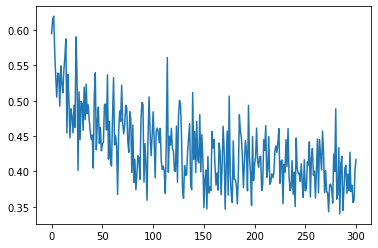

In [30]:
# Visualize learning (training loss)
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

In [31]:
class TestDataset(Dataset):
    def __init__(self,filename):
        datat = dftest
       
        self.samples = list(range(len(datat)))
        self.label = list(range(len(datat)))
        self.sz = 0
        idx = 0
        for index in range(len(datat)) :
          str1 = datat['Drug1_ID'][index]
          str2 = datat['Drug2_ID'][index]

          
          if (str1 in dictval) and (str2 in dictval) :
            mat1 = dictval[str1][0]
            mat2 = dictval[str2][0]
            mean1 = torch.mean(mat1, axis = 0)
            std1 = torch.std(mat1, axis = 0)
            mean2 = torch.mean(mat2, axis = 0)
            std2 = torch.std(mat2, axis = 0)
            vect = torch.cat([mean1, mean2, std1, std2], dim=0)
            self.samples[idx] = vect.detach().cpu()
            self.label[idx] = datat['label'][index]
            self.label[idx] = torch.tensor(self.label[idx], dtype=torch.int64)
            idx+=1
        self.sz = idx


    def __len__(self):
        return self.sz

    def __getitem__(self, idx):
        return self.samples[idx],self.label[idx]

datatest = TestDataset("sup_test.csv")
len(datatest)

16234

In [32]:
test_loader = DataLoader(datatest,batch_size=len(datatest), shuffle=True)
dffull = pd.DataFrame(columns = ['y_real','y_pred'])
with torch.no_grad():
    for test_batch in test_loader : 
      test_batch[0] = test_batch[0].to(device)
      test_batch[1] = test_batch[1].to(device)
      pred = model_ff(test_batch[0]) 
      pred_frac0 = pred[:,0]
      pred_frac1 = pred[:,1]
      if n_classes == 3 : 
        pred_frac2 = pred[:,2]
      pred = pred.argmax(dim=1)  
      dftt = pd.DataFrame()
      dftt["y_real"] = test_batch[1].tolist()
      dftt["y_pred"] = pred.tolist()
      dftt["y_predfrac0"] = pred_frac0.tolist()
      dftt["y_predfrac1"] = pred_frac1.tolist()
      if n_classes == 3 : 
        dftt["y_predfrac2"] = pred_frac2.tolist()
      dffull = dffull.append(dftt)
      print(f1_score(dftt['y_real'], dftt['y_pred'],average='macro'))

dffull.to_csv('tt.csv')
dffull.tail()

0.8867639856331047


,y_real,y_pred,y_predfrac0,y_predfrac1
16229,0,1,0.000298,9.997020e-01
16230,1,1,0.459506,5.404943e-01
16231,0,0,0.838414,1.615857e-01
16232,0,0,0.999979,2.122029e-05
16233,0,0,1.000000,3.885778e-14


In [34]:
datahead = pd.read_csv('tt.csv')

print(f1_score(datahead['y_real'], datahead['y_pred'],average='macro'))
print(f1_score(datahead['y_real'], datahead['y_pred'],average='micro'))
print(accuracy_score(datahead['y_real'], datahead['y_pred']))

confusion_matrix(datahead['y_real'], datahead['y_pred'])

0.8867639856331047
0.8867808303560428
0.8867808303560428


array([[7099, 1010],
       [ 828, 7297]])

In [35]:
dfttt = datahead.iloc[:,3:]
dfttt.head()

,y_predfrac0,y_predfrac1
0,5.311038e-07,9.999995e-01
1,1.000000e+00,1.595180e-32
2,1.775531e-03,9.982244e-01
3,2.196935e-06,9.999979e-01
4,3.737973e-05,9.999626e-01


In [36]:
probab = dfttt.to_numpy()

In [37]:
if n_classes==3 : 
  macro_roc_auc_ovo = roc_auc_score(datahead['y_real'],probab, multi_class="ovo", average="macro")
  print(macro_roc_auc_ovo)
  macro_roc_auc_ovo = roc_auc_score(datahead['y_real'],probab, multi_class="ovr", average="weighted")
  print(macro_roc_auc_ovo)
else : 
  auc = roc_auc_score(datahead['y_real'],datahead['y_predfrac1'])
  print('AUC: %.3f' % auc)

AUC: 0.931


In [38]:
if n_classes == 3 : 
  Y_test = datahead['y_real']
  y_score = probab
  # Use label_binarize to be multi-label like settings
  Y = label_binarize(Y_test, classes=[0, 1, 2])
  n_classes = Y.shape[1]

  Y_test = Y


  # For each class
  precision = dict()
  recall = dict()
  average_precision = dict()
  for i in range(n_classes):
      precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
      average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

  # A "micro-average": quantifying score on all classes jointly
  precision["micro"], recall["micro"], _ = precision_recall_curve(
      Y_test.ravel(), y_score.ravel()
  )
  average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")
  average_precision["macro"] = average_precision_score(Y_test, y_score, average="macro")
  print(average_precision["micro"])
  print(average_precision["macro"])

In [39]:
if n_classes == 3 :
  display = PrecisionRecallDisplay(
      recall=recall["micro"],
      precision=precision["micro"],
      average_precision=average_precision["micro"],
  )
  display.plot()
  _ = display.ax_.set_title("Micro-averaged over all classes")

Model: ROC AUC=0.931


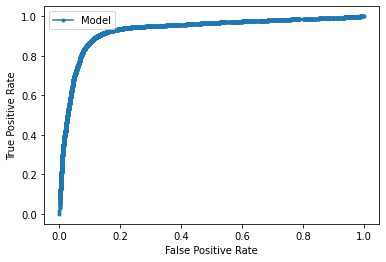

In [40]:

lr_auc = roc_auc_score(datahead['y_real'],datahead['y_predfrac1'])
# summarize scores

print('Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

lr_fpr, lr_tpr, _ = roc_curve(datahead['y_real'],datahead['y_predfrac1'])
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: f1=0.888 auc=0.926


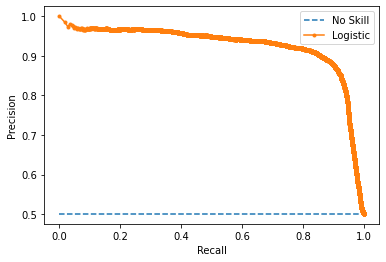

In [41]:
lr_precision, lr_recall, _ = precision_recall_curve(datahead['y_real'],datahead['y_predfrac1'])
lr_f1, lr_auc = f1_score(datahead['y_real'], datahead['y_pred']), metrics.auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(datahead['y_real'][datahead['y_real']==1]) / len(datahead['y_real'])
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [42]:


precision, recall, thresholds  = precision_recall_curve(datahead['y_real'], datahead['y_predfrac1'])
auc_score = metrics.auc(recall, precision)
auc_score

0.9258876164854745